In [1]:
# https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra-v2/blob/master/nbs/02-Background-Removal-with-SVD.ipynb

In [2]:
import imageio
imageio.plugins.ffmpeg.download()

In [3]:
import moviepy.editor as mpe
import numpy as np
import scipy
import cv2
from skimage.transform import rescale

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
video = mpe.VideoFileClip("VIDEO_003.mp4")

In [6]:
def create_data_matrix_from_video(clip, fps=5, scale=50):
    total_frames = fps * int(clip.duration)
    all_frames_array = []
    for index in range(total_frames):
        frame = clip.get_frame(index/float(fps))
        gray_scale_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray_scale_image, (0,0), fx=scale, fy=scale)
        all_frames_array.append(resized_frame.flatten())
    stacked_frames = np.vstack(all_frames_array)
    return stacked_frames.T


In [7]:
def create_data_matrix_from_video2(clip, fps=5, scale=50):
    return np.vstack(
        [
            cv2.resize(
                cv2.cvtColor(
                    clip.get_frame(i/float(fps)),
                    cv2.COLOR_BGR2GRAY
                ), (0,0), fx=scale, fy=scale
            ).flatten() for i in range(fps * int(clip.duration))
        ]
    ).T


In [8]:
scale = 0.5
dims = int(240*scale), int(320*scale)
fps = 60
M = []

In [9]:
M = create_data_matrix_from_video(video.subclip(0, 50), fps, scale)

In [10]:
print(dims, M.shape)

(120, 160) (19200, 3000)


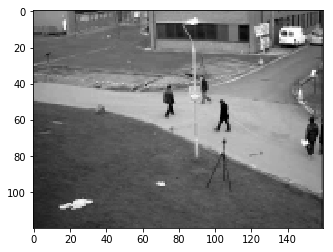

In [11]:
plt.imshow(np.reshape(M[:,140], dims), cmap="gray")

In [12]:
np.save("pedestrians_moving_60fps.npy", M)

In [13]:
plt.figure(figsize=(6, 6))

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

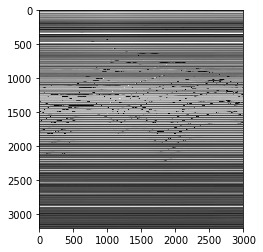

In [14]:
plt.imshow(M[::6, :], cmap="gray")

In [15]:
U, s, V = np.linalg.svd(M, full_matrices=False)

In [16]:
np.save("U.npy", U)
np.save("s.npy", s)
np.save("v.npy", V)

In [17]:
U.shape, s.shape, V.shape

((19200, 3000), (3000,), (3000, 3000))

In [18]:
reconstructed_matrix = U @ np.diag(s) @ V

In [19]:
np.allclose(M, reconstructed_matrix)

True

In [20]:
np.set_printoptions(suppress=True, precision=0)

In [21]:
np.diag(s[:6])

array([[920239.,      0.,      0.,      0.,      0.,      0.],
       [     0.,  28584.,      0.,      0.,      0.,      0.],
       [     0.,      0.,  24209.,      0.,      0.,      0.],
       [     0.,      0.,      0.,  22817.,      0.,      0.],
       [     0.,      0.,      0.,      0.,  19818.,      0.],
       [     0.,      0.,      0.,      0.,      0.,  19454.]])

In [22]:
s[0:2000:50]

array([920239.,   7347.,   4037.,   2758.,   2115.,   1696.,   1309.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.])

In [23]:
len(s)

3000

In [24]:
s[700]

9.14151983295492e-11

In [25]:
np.set_printoptions(suppress=True, precision=4)

In [26]:
U[:5, :5]

array([[-0.0079,  0.0031,  0.0018,  0.0003, -0.0004],
       [-0.0079,  0.0041,  0.0017,  0.0014,  0.0002],
       [-0.008 ,  0.0055,  0.0027,  0.0008, -0.0004],
       [-0.008 ,  0.0058,  0.0037,  0.0006, -0.0001],
       [-0.0082,  0.0047,  0.004 ,  0.0013, -0.0002]])

In [27]:
U.shape, s.shape, V.shape

((19200, 3000), (3000,), (3000, 3000))

In [28]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

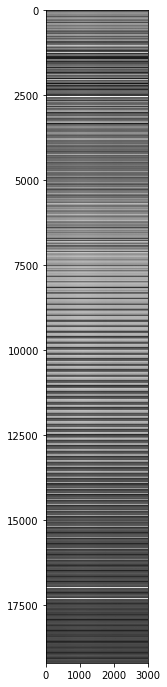

In [29]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

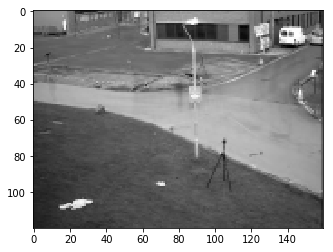

In [30]:
plt.imshow(np.reshape(low_rank[:, 140], dims), cmap="gray")

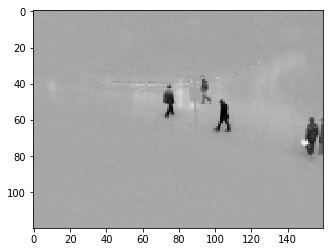

In [31]:
plt.imshow(np.reshape(M[:, 140] - low_rank[:, 140], dims), cmap="gray")

In [32]:
from moviepy.video.io.bindings import mplfig_to_npimage

In [33]:
def make_video(matrix, dims, filename):
    mat_reshaped = np.reshape(matrix, (dims[0], dims[1], -1))
    
    fig, ax = plt.subplots()
    def make_frame(t):
        ax.clear()
        ax.imshow(mat_reshaped[..., int(t*fps)])
        return mplfig_to_npimage(fig)
    
    animation = mpe.VideoClip(make_frame, duration=int(10))
    animation.write_videofile(filename, fps=fps)

[MoviePy] >>>> Building video only_people.mp4
[MoviePy] Writing video only_people.mp4


100%|█████████▉| 600/601 [00:34<00:00, 17.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: only_people.mp4 



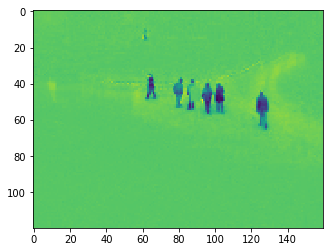

In [34]:
make_video(M - low_rank, dims, "only_people.mp4")

In [35]:
mpe.VideoFileClip("only_people.mp4").subclip(0, 10).ipython_display(width=300)

100%|█████████▉| 600/601 [00:00<00:00, 852.85it/s] 


In [36]:
import timeit
import pandas as pd

In [37]:
m_array = np.array([100, int(1e3), int(1e4)])
n_array = np.array([100, int(1e3), int(1e4)])

In [38]:
index = pd.MultiIndex.from_product([m_array, n_array], names=["# rows", "# cols"])

In [39]:
pd.options.display.float_format = '{:, .3f}'.format
df = pd.DataFrame(index=m_array, columns=n_array)

In [40]:
# takes way too much time.
#for m in m_array:
#    for n in n_array:
#        A = np.random.uniform(-40, 40, [m,n])
#        t = timeit.timeit('np.linalg.svd(A, full_matrices=False)', number=3, globals=globals())
#        df.set_value(m, n, t)

In [41]:
# new video SVD test

In [42]:
from moviepy.editor import concatenate_videoclips

In [47]:
raw_video2 = mpe.VideoFileClip("VIDEO_008.mp4")

In [48]:
video2 = raw_video2.subclip(0, 20)

In [49]:
concat_video = concatenate_videoclips([video2.subclip(0, 20), video.subclip(0, 10)])
concat_video.write_videofile("concatenated_video.mp4")

[MoviePy] >>>> Building video concatenated_video.mp4
[MoviePy] Writing video concatenated_video.mp4


100%|█████████▉| 300/301 [00:00<00:00, 471.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: concatenated_video.mp4 



In [50]:
concat_video = mpe.VideoFileClip("concatenated_video.mp4")

In [52]:
concat_video.ipython_display(width=300, maxduration=160)

100%|█████████▉| 300/301 [00:00<00:00, 1176.13it/s]


In [53]:
scale = 0.5
dims = (int(240 * scale), int(320 * scale))
fps = 60

In [54]:
N = create_data_matrix_from_video(concat_video, fps, scale)

In [55]:
np.save("concat_video_moving_60fps.npy", N)

In [56]:
N.shape

(19200, 1800)

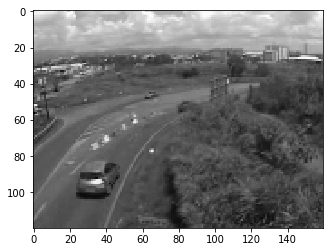

In [57]:
plt.imshow(np.reshape(N[:, 200], dims), cmap="gray")

In [58]:
U_concat, s_concat, V_concat = np.linalg.svd(N, full_matrices=False)

In [59]:
np.save("U_concat.npy", U_concat)
np.save("s_concat.npy", s_concat)
np.save("V_concat.npy", V_concat)

In [95]:
low_rank = U_concat[:, :10] @ np.diag(s_concat[:10]) @ V_concat[:10, :]
#low_rank = np.expand_dims(U_concat[:,0], 1) * s_concat[0] * np.expand_dims(V_concat[0,:], 0)

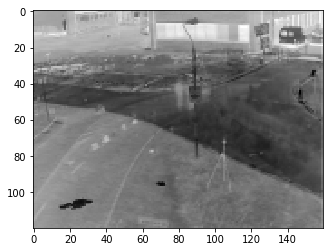

In [96]:
plt.imshow(np.reshape(U_concat[:, 1], dims), cmap="gray")

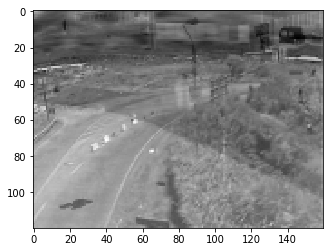

In [97]:
plt.imshow(np.reshape(U_concat[:, 2], dims), cmap="gray")

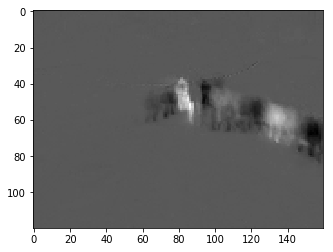

In [98]:
plt.imshow(np.reshape(U_concat[:, 3], dims), cmap="gray")

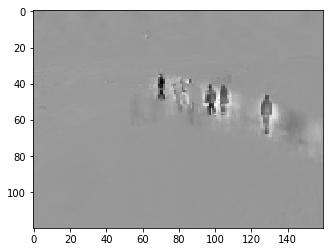

In [99]:
plt.imshow(np.reshape((N - low_rank)[:, -40], dims), cmap="gray")

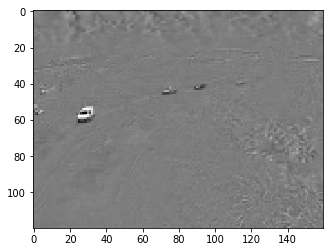

In [100]:
plt.imshow(np.reshape((N - low_rank)[:, 240], dims), cmap="gray")

In [101]:
# data compression

In [102]:
s[0:1000:50]

array([920239.2256,   7347.2975,   4036.5129,   2758.3199,   2115.3323,
         1696.232 ,   1309.4445,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ,
            0.    ,      0.    ,      0.    ,      0.    ,      0.    ])

In [126]:
k = 700
compressed_M = U[:,:k] @ np.diag(s[:k]) @ V[:k, :]

In [127]:
compressed_M.shape

(19200, 3000)

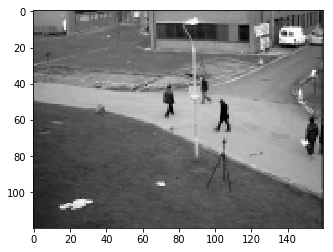

In [128]:
plt.imshow(np.reshape(compressed_M[:,140], dims), cmap='gray');

In [129]:
np.allclose(compressed_M, M)

True

In [130]:
np.linalg.norm(M - compressed_M)

3.108882440895584e-09

In [131]:
U[:,:k].shape, s[:k].shape, V[:k,:].shape

((19200, 700), (700,), (700, 3000))

In [132]:
((19200 + 1 + 3000) * 700) / (19200 * 3000)

0.2698038194444444

In [134]:
#%time u, s, v = np.linalg.svd(M, full_matrices=False)

In [135]:
M.shape

(19200, 3000)